## Setup

In [4]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os;

#os.environ["ACCELERATE_DISABLE_RICH"] = "1"

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


import sys
from functools import partial
import json
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
from sklearn.linear_model import LinearRegression
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import einops
from tqdm import tqdm
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import webbrowser
from IPython.display import display
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm
from eindex import eindex

# t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "monthly_algorithmic_problems" / "september23_sum"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.september23_sum.model import create_model
from monthly_algorithmic_problems.september23_sum.training import train, TrainArgs
from monthly_algorithmic_problems.september23_sum.dataset import SumDataset
from plotly_utils import hist, bar, imshow

device = t.device("mps") #t.device("cuda" if t.cuda.is_available() else "cpu")


MAIN = __name__ == "__main__"

## Dataset

In [15]:
dataset = SumDataset(size=1000, num_digits=4, seed=42).to(device)

## Transformer

In [6]:
filename = section_dir / "sum_model.pt"
args = TrainArgs(
    num_digits=4,
    trainset_size=100_000,
    valset_size=5_000,
    epochs=100,
    batch_size=512,
    lr_start=2e-3,
    lr_end=1e-4,
    weight_decay=0.001,
    seed=42,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    d_mlp=None,
    normalization_type="LN",
    use_wandb=True,
    device=device,
)

# Tranin and Save the model
# model = train(args)
# t.save(model.state_dict(), filename)

# Check we can load in the model
model = create_model(
    num_digits=4,
    seed=0,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    normalization_type="LN",
    d_mlp=None,
    device=device
)
model.load_state_dict(t.load(filename))

<All keys matched successfully>

## Goals

- Determine the activations actually responsible for prediction under two cases: 1) no carrying is required, 2) carrying is required
- Critically analyze the model's method of solving the problem
- Suggest ways to make the model solve the problem better

## Method Summary

#### Determine the "result" words (layer,head,seq) that drive the predictions (e.g. digits [-5:-1] )
- Use mean ablation on a word-by-word basis at the "result" stage of the calculation to flag the words that matter
- In layer 1, the only "result" words that can matter are the digits themselves [-5:-1], however some heads in layer 1 may be unnecessary for some digits. 

#### Determine which inputted words (seq) cause meaningful variations in each word at the "result" stage (layer,head,seq).
- If a "result" word impacts a final predicted digit, refine the understanding by replacing the activation at the "result" stage with a cached activation from performing mean ablation on the inputted word. 


## Obvious model problems

The model is set up to calculate the most signifcant digit first (e.g. it has to do the complete calculation to predict the digit -5). 

There is published research that indicates that transformers train much faster and more successfully if the least significant digit (-2) is predicted first (e.g. the order of the digits is reversed)

## Conclusions

The 'no carrying' dataset delivers the most simple interpretation. It may be possible to drive the understanding all the way down to the deepest level. 

Carrying presents issues due to the setup of the problem (highest significant digit first), and the model solves the problem in a very complicated way. 

The more difficult the problem, the more the model suffers from un-necessary multi-colinearity with heads (and layers) duplicating and reversing each other's work. I'll show examples below. 

A more interpritable model would regularize between layers (and heads) to get rid of as much multi-colinearity as possible. 



#### ** <i>Code below, keep scrolling to look at pictures</i> **

In [18]:
import torch as t
import functools
import matplotlib.pyplot as plt
import numpy as np

LAYERS = 2
HEADS  = 3
WORDS  = 14
DIGITS = [-5,-4,-3,-2]
LABELS = ["0","1","2","3","+","5","6","7","8","-5","-4","-3","-2","-1"] 

# Filter the dataset to only include examples where there is no carrying if carry_digit = [0,0,0,0]
# To specify the digit for carrying set the value equal to 1
def split_dataset( dataset, carry_digit = [0,0,0,0] ) :
    rows = []
    for row in dataset :
        row = row.to(t.int)
        check = 0
        for  digit,digit2,carry in zip(row[0:4],row[5:9],carry_digit) :
            if ( digit + digit2 <= 9 and carry == 0) or  ( digit + digit2 > 9 and carry == 1) :
                check +=1
        if (check == 4) :
            rows.append( row )
    rows = t.stack(rows)
    return rows

# Count the errors in the dataset
# This can be made much more efficient
def error_count( logits, dataset, digit) :
    preds = logits.softmax(dim=-1).argmax(dim=-1)
    return len( [ [ex,pred] for ex,pred in zip(dataset,preds) if (t.sum(t.abs( ex[digit+1]  - pred[digit]) )>0)  ]) > 0 
 
# Swap the activation to the cache's activation at the "result" stage
def head_input_selective_ablation_hook(result: Float[Tensor, "batch seq head_idx d_model"],hook: HookPoint,cache,head: int,layer: int,seq: int) -> Float[Tensor, "batch seq head_idx d_model"]:
    result[:, seq, head, :] = cache["result" , layer][:, seq, head, :]
    return result

def head_input_hook( cache, head, layer, word) :
    return functools.partial(head_input_selective_ablation_hook,cache=cache, head=head, layer=layer, seq=word)

# Calculate an array of cached activations that result from averaging each inputted word separately
# This is used to calculate the significance of each input word in the sequence on each of the "result" activations
# The trace_cache array is a list of cached activations for each mean-ablated input word
# this can be done for input words at layer 0 or layer 1 depending on how trace_cache was calculated
def trace_inputs( trace_cache, dataset, head, layer, word, digit) :
    significance = np.ones(WORDS,bool)
    for seq in range(WORDS) :
        model.reset_hooks()
        model.add_hook( utils.get_act_name("result", layer), head_input_hook(trace_cache[seq],head,layer,word)  )
        logits_ablate, cache_ablate = model.run_with_cache(dataset)
        model.reset_hooks()
        significance[seq] = error_count(logits_ablate, dataset, digit) 
    return significance

# Swap the activation to the cache's activation at the "result" stage using mean ablation
# Swap on a word by word basis to test the results of the calculation on each word
def head_selective_ablation_hook(result: Float[Tensor, "batch seq head_idx d_model"],hook: HookPoint,cache,head: int,layer: int,seq: int) -> Float[Tensor, "batch seq head_idx d_model"]:
    result[:, seq, head, :] = cache["result" , layer][:, seq, head, :].mean(0).unsqueeze(0)
    return result

def head_hook( cache, head, layer, word) :
    return functools.partial(head_selective_ablation_hook,cache=cache, head=head, layer=layer, seq=word)

# Determine the significance of each inputted word (0:14) in the "result" activations on each calculated digit (e.g. -5:-1)
# - if there are errors when ablating, then the calulation matters and record True
# - if there are no errors, then the calculation does not matter and record False
def selectively_ablate_head( cache, trace_cache, dataset, head, layer ) :
    significance = {}
    for word in range(WORDS) :
        model.reset_hooks()
        model.add_hook( utils.get_act_name("result", layer), head_hook(cache,head,layer,word)  )
        logits_ablate, cache_ablate = model.run_with_cache(dataset)
        model.reset_hooks()
        for d,digit in enumerate(DIGITS) :
            if ( error_count(logits_ablate, dataset, digit) ) :
                significance[(word,digit)] = trace_inputs( trace_cache, dataset, head, layer, word, digit) 
            else :
                significance[(word,digit)] = [] 
    return significance  

# Swap the inputted word at the specified layer with the cached activation at the "resid_pre" stage
# this will help determine the significance of each inputted word on the "result" activations
def input_ablation_hook(resid_pre: Float[Tensor, "batch seq d_model"],hook: HookPoint,cache,layer: int,seq: int) -> Float[Tensor, "batch seq d_model"]:
    resid_pre[:, seq, :] = cache["resid_pre", layer][:,seq,:].mean(0).unsqueeze(0)
    return resid_pre

def input_hook( cache, layer, seq) :
    return functools.partial(input_ablation_hook,cache=cache,layer=layer,seq=seq)

# Calculate an array of cached activations that result from averaging each inputted word separately
# This can be done at layer 0 or layer 1    
def run_input_sensitivity(cache, dataset, layer=0 ) :
    trace_cache = []
    for seq in range(WORDS) :
        model.reset_hooks()
        model.add_hook( utils.get_act_name("resid_pre", layer), input_hook(cache,layer,seq)  )
        logits_ablate, t_cache = model.run_with_cache(dataset)
        trace_cache.append( t_cache )
        model.reset_hooks()
    return trace_cache

# Using mean ablation on a word-by-word basis at the "result" stage, calculate the significance of each inputted word
# for eah head in each layer
# If the word is signifcant, go back and see which inputted words matter in the calculation. 
def ablate_heads(cache, trace_cache, dataset):
    return {(layer, head): selectively_ablate_head(cache, trace_cache, dataset, head, layer) for layer in range(LAYERS) for head in range(HEADS)}


## Ablation model runs (takes about 10min on a M2 macbook Air )

1) Create a cache with the "no carry" dataset (e.g. Every predicted digit is simply the sum of two other digits)
2) Create an array of caches for activations from mean ablating each of the 14 inputted word sepaerately (e.g. 1111+1111=2222)
3) Repeat the process for the full dataset.

In [19]:
model.reset_hooks()

# base run has no carry digits. 
dataset_no_carry = split_dataset(dataset.toks, carry_digit = [0,0,0,0] )
logits,cache     = model.run_with_cache(dataset_no_carry)

# caches for mean ablating each inputted word separately, no carry dataset
trace_cache_no_carry    = run_input_sensitivity(cache, dataset_no_carry)

# ablations at the "result" stage on a word-by-word basis for each head in each layer, no carry dataset
ablations_no_carry      = ablate_heads(cache, trace_cache_no_carry, dataset_no_carry )

# caches for mean ablating each inputted word separately for the enitre dataset, full dataset
trace_cache             = run_input_sensitivity(cache, dataset.toks)

# ablations at the "result" stage on a word-by-word basis for each head in each layer, full dataset
ablations               = ablate_heads(cache, trace_cache, dataset.toks)

#### ** <i>Code below, keep scrolling to look at pictures</i> **

In [20]:
def value(ablate, word) :
    return [ len( ablate[(word,d)] ) > 0 for d in DIGITS ]


def visualize_ablation_digit(ablations, digit=None ) :

    data = {}
    for layer in range(2) : 
        x = []
        for head in range(3):
            ablate = ablations[ (layer,head) ]
            if digit is None :
                x.append([ int( np.any( value(ablate,word) ) ) for word in range(WORDS) ])
            else :
                x.append([ int( len( ablate[(word,digit)] ) > 0 ) for word in range(WORDS) ] ) 
        data[f"layer {layer}"] = x

    fig, axes = plt.subplots(nrows=len(data), figsize=(6, 3))
    for ax, (layer_name, layer_data) in zip(axes, data.items()):
        cax = ax.matshow(layer_data, cmap="Blues")
        ax.set_title("Layer " + str(layer_name) + " Calc determining digit " + str(digit) )
        ax.set_ylabel('Head')
        ax.set_xlabel('Word')
        
        ax.set_xticklabels(LABELS)
        ax.set_yticks(range(len(layer_data)))
        ax.set_xticks(range(len(layer_data[0])))
 

    # fig.colorbar(cax, ax=axes.ravel().tolist(), orientation='vertical')
    plt.tight_layout()
    plt.show()

def visualize_ablation_digit_heads(ablations, digit, skip=False,title=None ) :

    def make_array( ablations, digit, layer, head ) :
        ablate = ablations[ (layer,head) ]
        arr = np.zeros((WORDS,WORDS),dtype=int)
        for word in range(WORDS) :
            if len( ablate[(word,digit)] ) > 0 :
                arr[:,word] = ablate[(word,digit)].astype(int)
        return arr

    if (skip) :
        layers = [1]
    else :
        layers = [0,1]

    fig, axs = plt.subplots(LAYERS,HEADS, figsize=(HEADS*3.5, len(layers)*3.5))
    if title is not None :
        fig.suptitle(title)

    for layer in layers:
        for head in range(HEADS):
            ax = axs[layer, head] if LAYERS > 1 else axs[head]
            arr = make_array( ablations, digit, layer, head )
                
            # Using pcolormesh instead of matshow
            cax = ax.pcolormesh(arr, cmap='Blues', edgecolors='w', linewidth=0)
            
            ax.set_ylabel('Inputted Words')
            ax.set_xlabel('\"Result\" words')

            # Set the ticks to be at the middle of the cells
            ax.set_xticklabels(LABELS)
            ax.set_yticklabels(LABELS)
            ax.set_xticks(np.arange(WORDS) + 0.5, minor=False)
            ax.set_yticks(np.arange(WORDS) + 0.5, minor=False)
            # ax.set_xticks(range(len(tokens)-1))
            # ax.set_yticks(range(len(tokens)-1))
            ax.set_xticks(np.arange(-.5, WORDS-.5,1), minor=True)
            ax.set_yticks(np.arange(-.5, WORDS-.5,1), minor=True)
            ax.grid(which='minor', color='b', linestyle='-', linewidth=.5)
            
            ax.invert_yaxis()

            ax.set_title(f'Layer {layer}, Head {head}')
    plt.subplots_adjust(hspace=0.5) 
    plt.show()


### Determine the calculations important for predicting digit -2 using the no-carry dataset.

(see graph below)

- Only words 3 and 8 should matter. Layer 0, Head 1,2 "result" calc for word 1 looks suspect because it can't possibly contain relevant information for the calculation. 

- Layer 0, Head 0 can be completely mean ablated

- In Layer 1 all three heads are required for the calculation. My guess is that they are highly colinear operations. 

/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(LABELS)


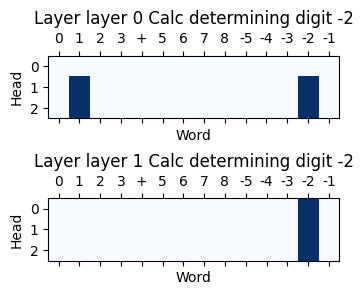

In [21]:
visualize_ablation_digit(ablations_no_carry,-2)

### Which inputted words determine digit -2? 

(see graph below)

We know that the only words that matter to predict digit -2 are word 3 and word 8. This is evident in Layer 0 (h1,h2) and Layer 1 (h0,h1 and h2) But what is going on with inputted word 1 in h1 and h2? 

There must be high negative correlation between layer 0, word 1 h1 and h2 activations beacuse word 1 can't matter if the predictions are indeed correct. (Note:  by the time the calc reaches Layer 1, there is actually no sensitivity to word 1)Examining the pearson correlation on an element-wise basis, we see that layer 0, word 1 h1 and h2 calcs are indeed strongly negatively correlated (e.g. -58% ). This negative correlation enables the effects of layer 0, word 1 h1 and h2 to cancel. 

Wouldn't it be better if the model was regularized so that this didn't happen? 


/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(LABELS)
/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(LABELS)


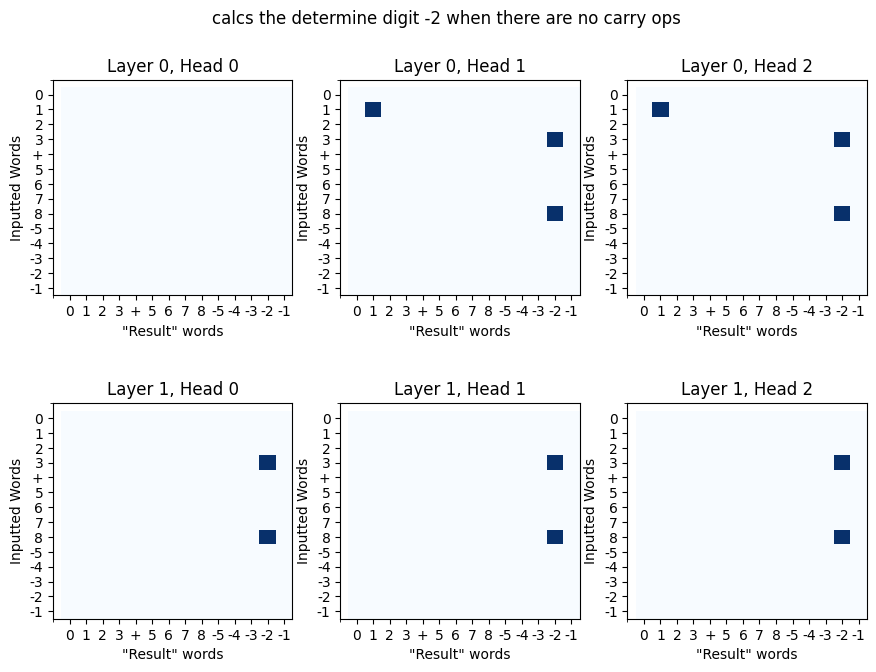

Average Correlation of word 1 for layer 0, head 1 and head 2 is  -0.5855909729685732


In [22]:
visualize_ablation_digit_heads(ablations_no_carry,-2,title="calcs the determine digit -2 when there are no carry ops")

import numpy as np
from scipy.stats import pearsonr


layer = 0
head0 = 1
head1 = 2
seq   = 1
a = cache["result" , layer][:, seq, head0, :].squeeze().squeeze()
b = cache["result" , layer][:, seq, head1, :].squeeze().squeeze()

A = a.detach().cpu().numpy()
B = b.detach().cpu().numpy()

# Calculate element-wise Pearson correlation
element_wise_correlation = np.array([pearsonr(A[:, i], B[:, i])[0] for i in range(A.shape[1])])

# print("Element-wise Correlation Coefficients:", element_wise_correlation)
print("Average Correlation of word 1 for layer 0, head 1 and head 2 is ", np.average(element_wise_correlation ) ) 


### Overall, what calculations matter at the result stage of layer 0 and layer 1 for all predicted digits? 

(see graphs below)

#### dataset : no carry
- Most of h0 in Layer 0 is irrelevant except for word "=".

- Whole blocks of Layer 0 h1 and h2 are irrelevant as well. 

- In layer 1 (as expected) the only blocks that matter are the ones that form the final output. All heads contribute.

#### dataset : full  (e.g. with carries)
- many more calcs are used, h0 becomes more useful. 

/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(LABELS)


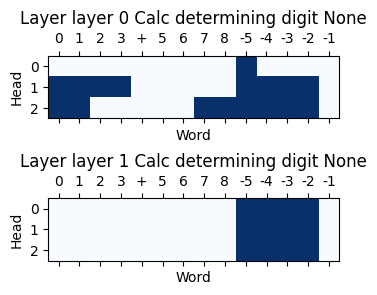

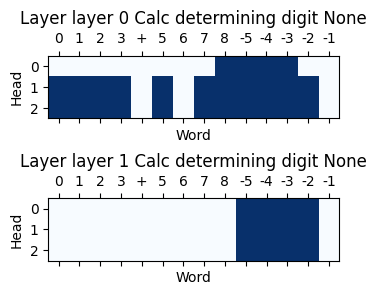

In [23]:
visualize_ablation_digit(ablations_no_carry)
visualize_ablation_digit(ablations)

## Which result calcs predict digit -5?

#### dataset : full  (e.g. with carries)

- A lot is going on to determine digit -5. The full calculation has to be completed to do all the potential carry operations. 

- Still, in some ways it is remarkable how sparse the plots are. 

- Layer 0 word 0 , h1 and h2 looks like another obvious case of needless multi-colinearity. 

/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(LABELS)
/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(LABELS)


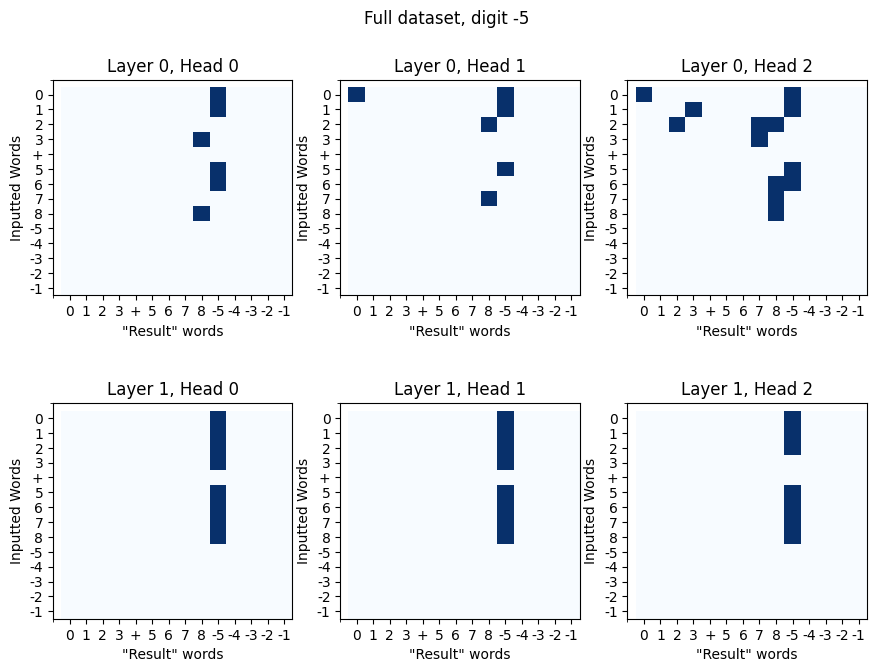

In [24]:
visualize_ablation_digit_heads(ablations,-5,title="Full dataset, digit -5")

#### Which result calcs predict digit -5?

#### dataset : no carry
- Words 3 and 8 are sufficient to calculate digit -5.  Clearly some intermediate activations are sensitive to many additional words. 

- Layer 0 h1 and h2 use different residual stream word space to write their outputs.

- Layer 0 h0 and h1 write to the same residual stream word space. 

- Layer 1 has to undo the effects of Layer 0.  

- There is massive colinearity problems between layers.  


/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(LABELS)
/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2403558952.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(LABELS)


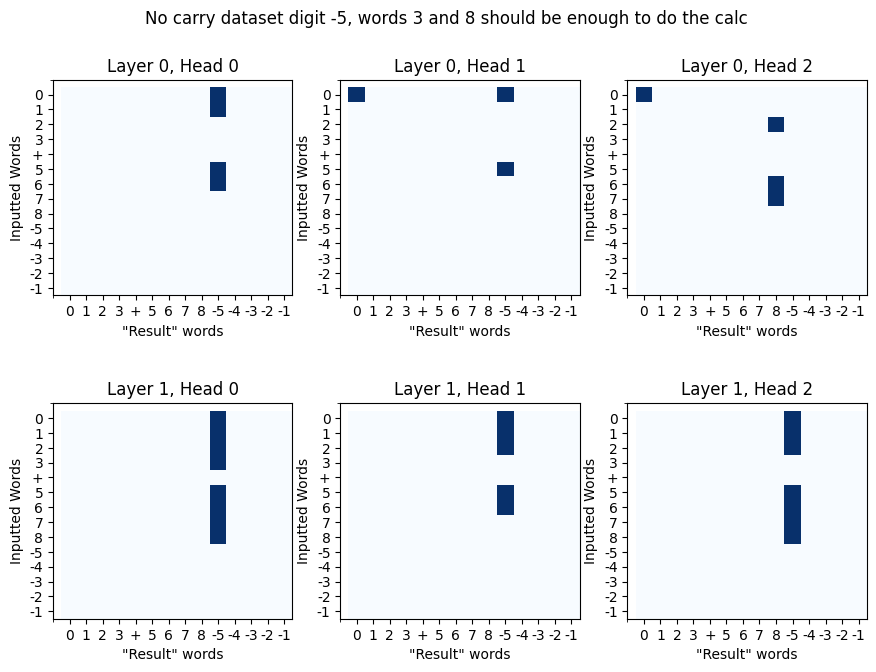

In [25]:
visualize_ablation_digit_heads(ablations_no_carry,-5,title="No carry dataset digit -5, words 3 and 8 should be enough to do the calc")

#### Let's look at the internal representations of digits
#### ** <i>Code below, keep scrolling to look at pictures</i> **

In [26]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def pca_the_points(points, n_components=10, graph=True):

    n_components=min(n_components,points.size(0))

    pca = PCA(n_components=n_components)
    data = points.detach().cpu().numpy()
    pca_result = pca.fit_transform(data)

    # Get the two components
    comp1 = pca.components_[0]
    comp2 = pca.components_[1]

    # Print the explained variance by each component
    print("Explained variance by component:", np.round(pca.explained_variance_ratio_,2)*100)

    if graph:
        # Plotting the explained variance
        plt.figure(figsize=(8, 5))
        plt.bar(range(n_components), pca.explained_variance_ratio_, align='center')
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Explained Variance by Principal Component")
        plt.show()

     # Create a bar chart
        width = 0.4
        indices = np.arange(48)

        plt.figure(figsize=(12, 6))
        bar1 = plt.bar(indices, pca.components_[0], width, color='b', label='Principal Component 1')
        bar2 = plt.bar(indices + width, pca.components_[1], width, color='r', label='Principal Component 2')
        plt.xlabel("Dimensions")
        plt.ylabel("Weight")
        plt.title("Weights of Dimensions for First Two Principal Components")
        plt.xticks(indices + width / 2, indices)  # X-axis labels (centered)
        plt.legend()

        plt.tight_layout()
        plt.show()


        n=points.size(0) # n=pca_result.shape[0] number of points to plot

        xi = 0
        yi = 1


        plt.figure(figsize=(8, 8))
        plt.scatter(pca_result[:n, xi], pca_result[:n, yi], s=50, c='blue', edgecolors='k', marker='o', alpha=0.7)

        for i in range(n) :
            plt.annotate(i, (pca_result[i, xi], pca_result[i, yi]), fontsize=12, ha="right")

        # Setting labels and title
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.xlim(-1.5, 1.5)  # Set the x-axis limits 
        plt.ylim(-1.5, 1.5)  # Set the y-axis limits
        plt.title("Projection of Original Vectors on First Two Principal Components")
        plt.grid(True)

        plt.show()

    return comp1, comp2

def compute_direction( aout, comp1, comp2 ) :
    c1 = t.tensor(comp1, device=device)
    c2 = t.tensor(comp2, device=device)
    return t.stack( (t.einsum('...d, d -> ...', aout, c1), t.einsum('...d, d -> ...', aout, c2)),dim=-1 )

def compute_plot_quivers( start, finish, comp1, comp2 ) :
    points  = compute_direction( start, comp1, comp2 ).reshape(-1,2).detach().cpu().numpy()
    vectors = compute_direction( finish - start, comp1, comp2 ).reshape(-1,2).detach().cpu().numpy()
    return points, vectors


import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_points( model,  points, comp1, comp2, points_result=None, points_values=None, logits=None, index=-5, lim=3) :

    if (points_result is None) :
        if (logits is not None) :
            points_result = logits.softmax(dim=-1).argmax(dim=-1)[:,index+1].detach().cpu().numpy()
        else :
            if (points_values is None) :
                points_values = points[:, 0][:, np.newaxis] * comp1 + points[:, 1][:, np.newaxis] * comp2
                points_values = t.tensor(points_values, device=device)
            points_output = model.unembed(model.ln_final(points_values.unsqueeze(1))).softmax(dim=-1)
            points_result = points_output.argmax(dim=-1).detach().cpu().numpy()

    print(points_result.shape)


    # Step 1: Create a 2D grid of points
    x = np.linspace(-lim, lim, 400)
    y = np.linspace(-lim, lim, 400)
    X, Y = np.meshgrid(x, y)

    def basic_function(x, y):
        z = x[:,:,np.newaxis] * comp1 + y[:,:,np.newaxis] * comp2
        
        # Convert z to a PyTorch tensor
        z_tensor = t.tensor(z, dtype=t.float32,device=device)


        #logits.softmax(dim=-1).argmax(dim=-1)

        output = model.unembed(model.ln_final(z_tensor)).softmax(dim=-1)
        result = output.argmax(dim=-1).detach().cpu().numpy()
        return result
    
    Z = basic_function(X, Y)

    # Get global min and max values
    global_min = min(Z.min(), points_result.min())
    global_max = max(Z.max(), points_result.max())

    # Define a normalization based on the global min/max
    norm = mcolors.Normalize(vmin=global_min, vmax=global_max)

    # Step 3: Plot the z values
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X, Y, Z, shading='auto', cmap='tab10', norm=norm)
    plt.colorbar(label='Z Value')

    # Plot points on top of the mesh plot with colors based on their z-values
    # plt.scatter(points[:, 0], points[:, 1], c=points_result, s=40, edgecolors='w', cmap='tab10', norm=norm)

    plt.scatter(points[:, 0], points[:, 1], 
            c='black',  # color for the point itself
            s=20,
            edgecolors=cm.tab10(points_result),  # using points_result for edge colors
            linewidths=2,  # thickness of the edges
            facecolors='black',  # same as c parameter
            cmap='tab10', 
            norm=norm)

    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title('Predicted digit')
    plt.show()






## Ultimately, only 2 principal components matter. 

####  Let's examine the embeddings of the digits direclty before the unembedding



Explained variance by component: [56. 40.  1.  1.  1.  0.  0.  0.  0.  0.]


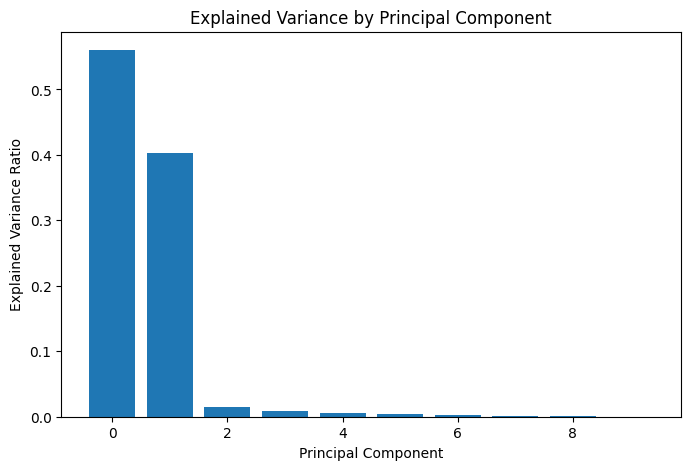

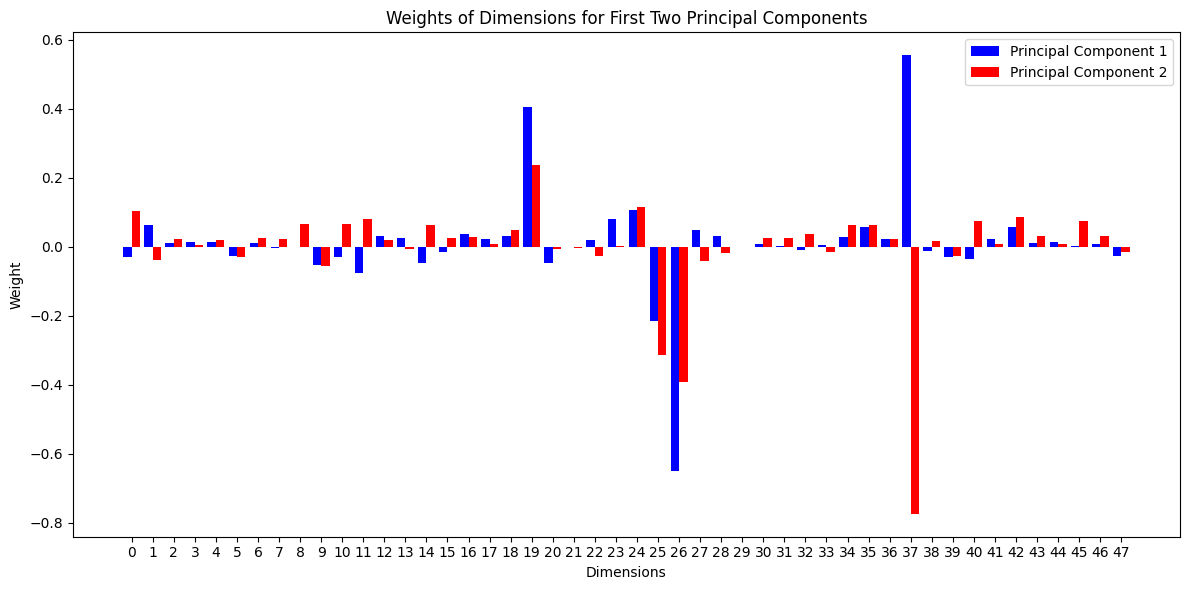

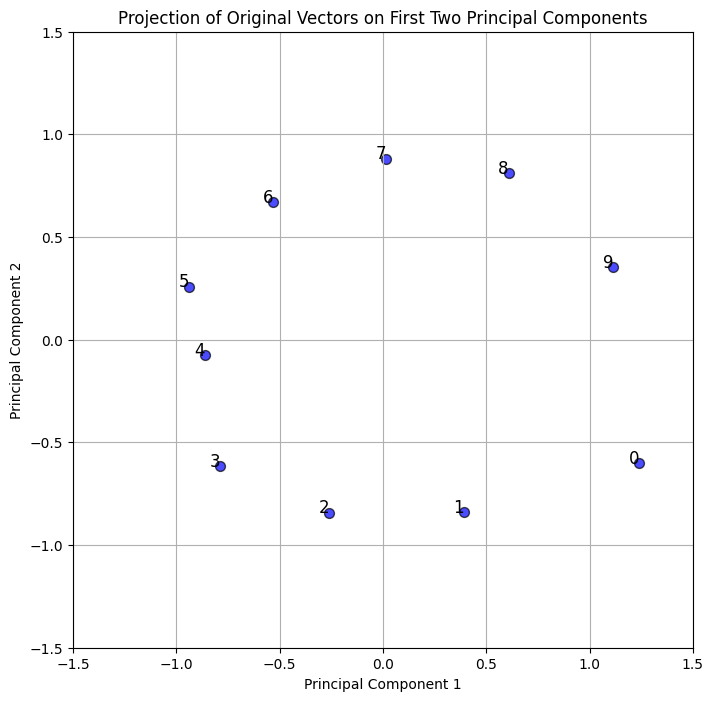

In [27]:
examples = [ [0,0,0,0,10,i,i,i,i,11,i,i,i,i] for i in range(10) ]
model.reset_hooks()
logits, cache       = model.run_with_cache(t.tensor(examples, device=device))
post_embeddings_l1  = cache["resid_post", 1][:,-4:,:].mean(dim=1).squeeze()
cp1,cp2 = pca_the_points(post_embeddings_l1, graph=True)


#### This is a plot of one word in the residual stream directly before the unembedding, as projected on the two principle components. (e.g. all 1000 points for word -4) 

- With the exception of 1 data point, all the points are predicted well with 2 principle components. 

(1000,)


/var/folders/pg/82z_8_tj0_5b3gbf4gz6_w880000gn/T/ipykernel_69042/2375109578.py:135: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  plt.scatter(points[:, 0], points[:, 1],


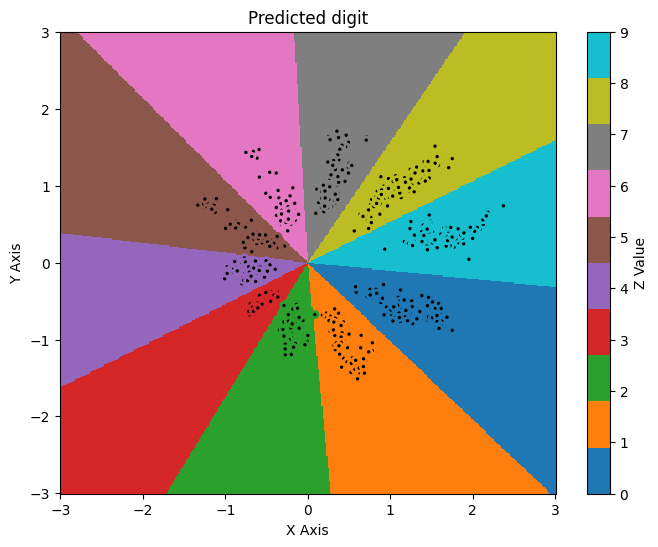

In [28]:
index = -4

logits, cache       = model.run_with_cache(dataset.toks)
post_embeddings_l1  = cache["resid_post", 1][:,index,:]

points_result = dataset.toks[:,index+1].detach().cpu().numpy()

points ,vectors  = compute_plot_quivers( post_embeddings_l1 , post_embeddings_l1 , cp1, cp2 )
plot_points(model, points , cp1, cp2 ,points_result=points_result)
